## Test Bit Occupancy

In [55]:
## Now sort by code 
#if it was 2 bit division: 
#0: 0, 2, 4, 6,
#1: 1, 3, 5, 7 

from lsst.daf.butler import Butler
from multiprocessing import Pool
import pickle as pkl
import numpy as np
import statistics
import os
#import fast_histogram
import argparse
from operator import add
import matplotlib.pyplot as plt

## get dataref, trim image, generate histogram 
def getFlattenedArray(detectornum, runnum, rtype, exposurenum):  
    #repo_path = "/repo/ir2" # this was the repo before the camera moved to the summit 
    repo_path = "/sdf/group/rubin/repo/main" #the repo path has changed, allows access to EO Run 7 (and before)
    
    butler = Butler(repo_path, collections=['LSSTCam/photodiode','LSSTCam/raw/all'], instrument='LSSTCam')
    registry = butler.registry
    recordClasses = butler.registry.queryDimensionRecords('detector', where="instrument='LSSTCam'")
    det_raft_pairs = sorted([(rc.id, rc.full_name) for rc in recordClasses])
    sensorname = det_raft_pairs[detectornum][1]
    print(sensorname)
    
    where = f"exposure.science_program='{runnum}' and exposure.observation_type ='{rtype}'"
    collections = 'LSSTCam/raw/all'
    dataId = {'detector': detectornum}
    
    # get datarefs 
    datarefs = list(butler.registry.queryDatasets(datasetType='raw', collections=collections, where=where, dataId=dataId))
    #exp = butler.get(datarefs[0]) #use just the first image to get the order of amps
    #det = exp.getDetector()
    amps_list = ["C00", "C01", "C02","C03","C04","C05","C06", "C07", "C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
    #ampNames = [amp.getName() for amp in det if amp.getName() in amps_list] #the order in which the channels are in the dataset 
    ## cut 13% of the time for one iteration by writing explictly the order of the amps 
    ## but run above to get this order explicitly
    ampNames = ['C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C07', 'C06', 'C05', 'C04', 'C03', 'C02', 'C01', 'C00']

    # start configuration for countsdict 
    flattenedarraydict = {} 
        
    trimtops = ["C00", "C01", "C02","C03","C04","C05","C06", "C07"]
    trimbottoms = ["C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]

    #bins = np.arange(26740, 26800)
    bins = np.arange(2e4, 2e5)
    
    for dataref in datarefs[exposurenum:exposurenum+1]:
        exp = butler.get(dataref) 
        det = exp.getDetector()
        trimmed_ims = [exp.getMaskedImage()[amp.getRawDataBBox()].getImage() for amp in det if amp.getName() in amps_list]
        int_ims = [trimmed_im.getArray().astype(int) for trimmed_im in trimmed_ims]
        trimmeddict = {ampName: int_ims for ampName, int_ims in zip(ampNames, int_ims)}
        
        for amp in trimmeddict: 
            singlearray = trimmeddict[amp] 
            flattenarray = singlearray.flatten() 

            if amp not in flattenedarraydict.keys(): 
                flattenedarraydict[amp] = flattenarray  
    
    return flattenedarraydict 

def sortBinsModGeneric(valuestosort, mod):    
    bindictionary = {i: 0 for i in range(mod)}
    
    for value in valuestosort:
        bin_index = value % mod
        bindictionary[bin_index] +=1 
    
    return bindictionary

def getBinsSorted(exposurenum):
    flattenedarraydict =  getFlattenedArray(90, "13144", "flat", exposurenum)
    binsrepresented = flattenedarraydict["C01"]

    print("the mean signal in ADU is", np.mean(binsrepresented))
    
    seeMods = [2, 4, 8, 16, 32]
    
    fig, axes = plt.subplots(5, 1, figsize=(9, 25))  # 2x1 grid 
    
    index = 0 
    for x in seeMods: 
        bindictionary = sortBinsModGeneric(binsrepresented, x)
        axes[index].bar(bindictionary.keys(), bindictionary.values(), width=1, color='g', edgecolor='black')
        axes[index].set_title(f"13144, det 90, C01, single exposure mod {x}")
        axes[index].set_xticks(np.arange(0, x, 2))
        axes[index].set_ylabel("counts")
        axes[index].set_xlabel(f"signal mod {x}")
        index +=1 

R22_S00
the mean signal in ADU is 26767.155370020606


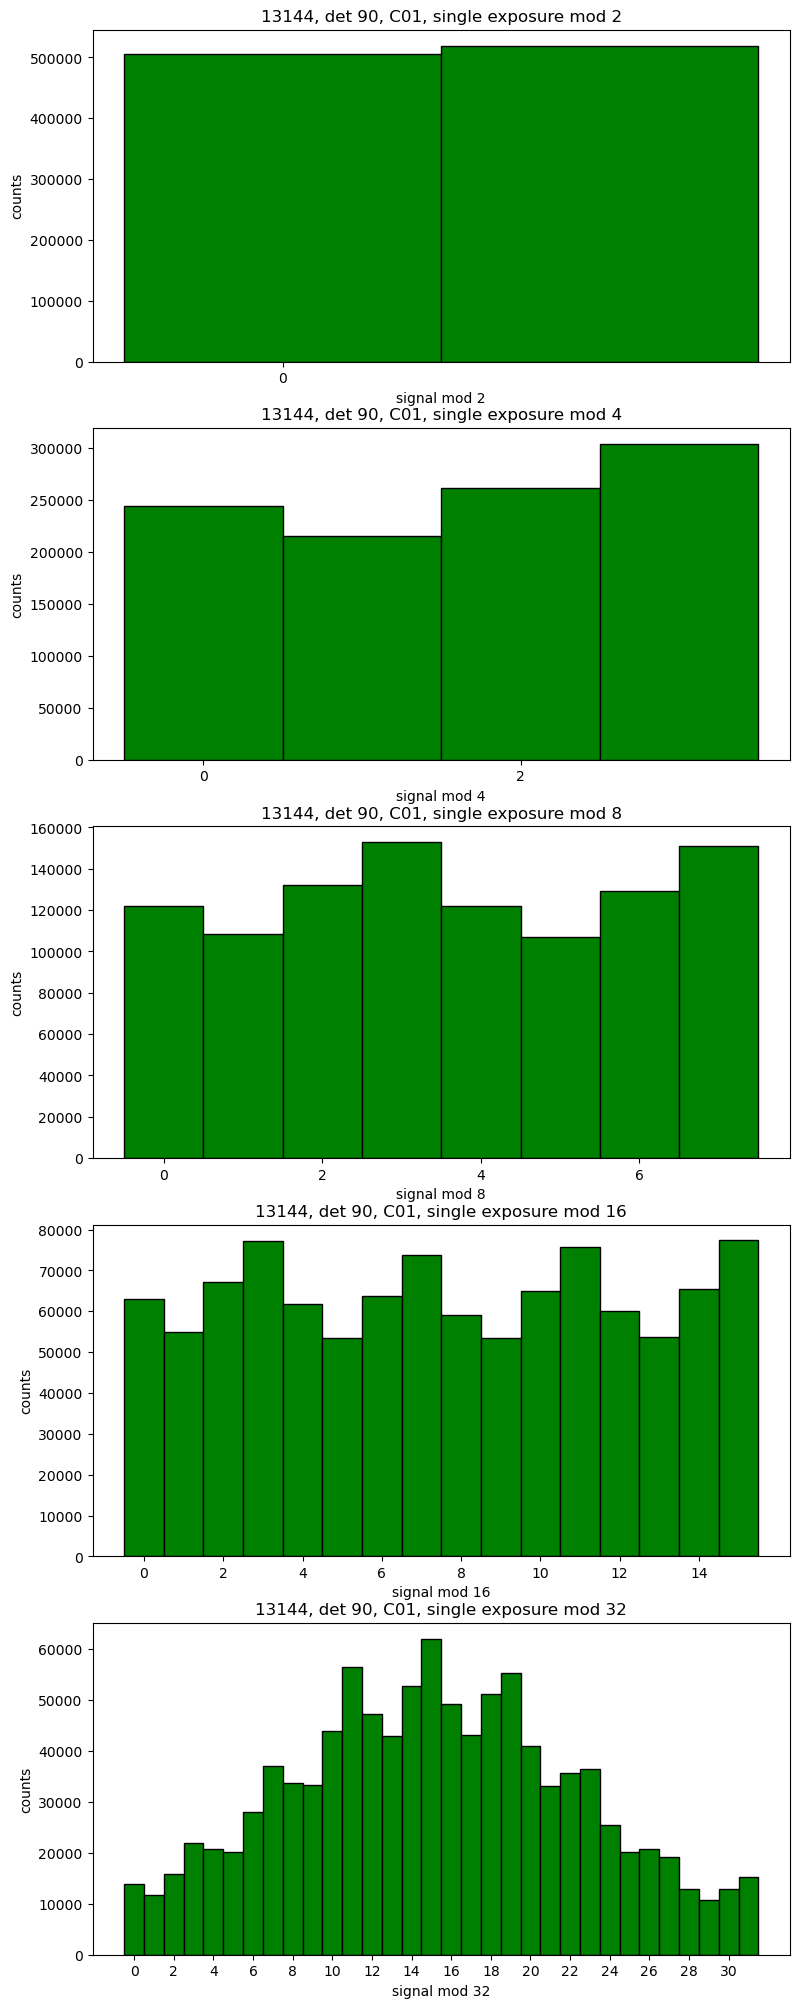

In [56]:
getBinsSorted(0)

R22_S00
the mean signal in ADU is 62957.46631005713


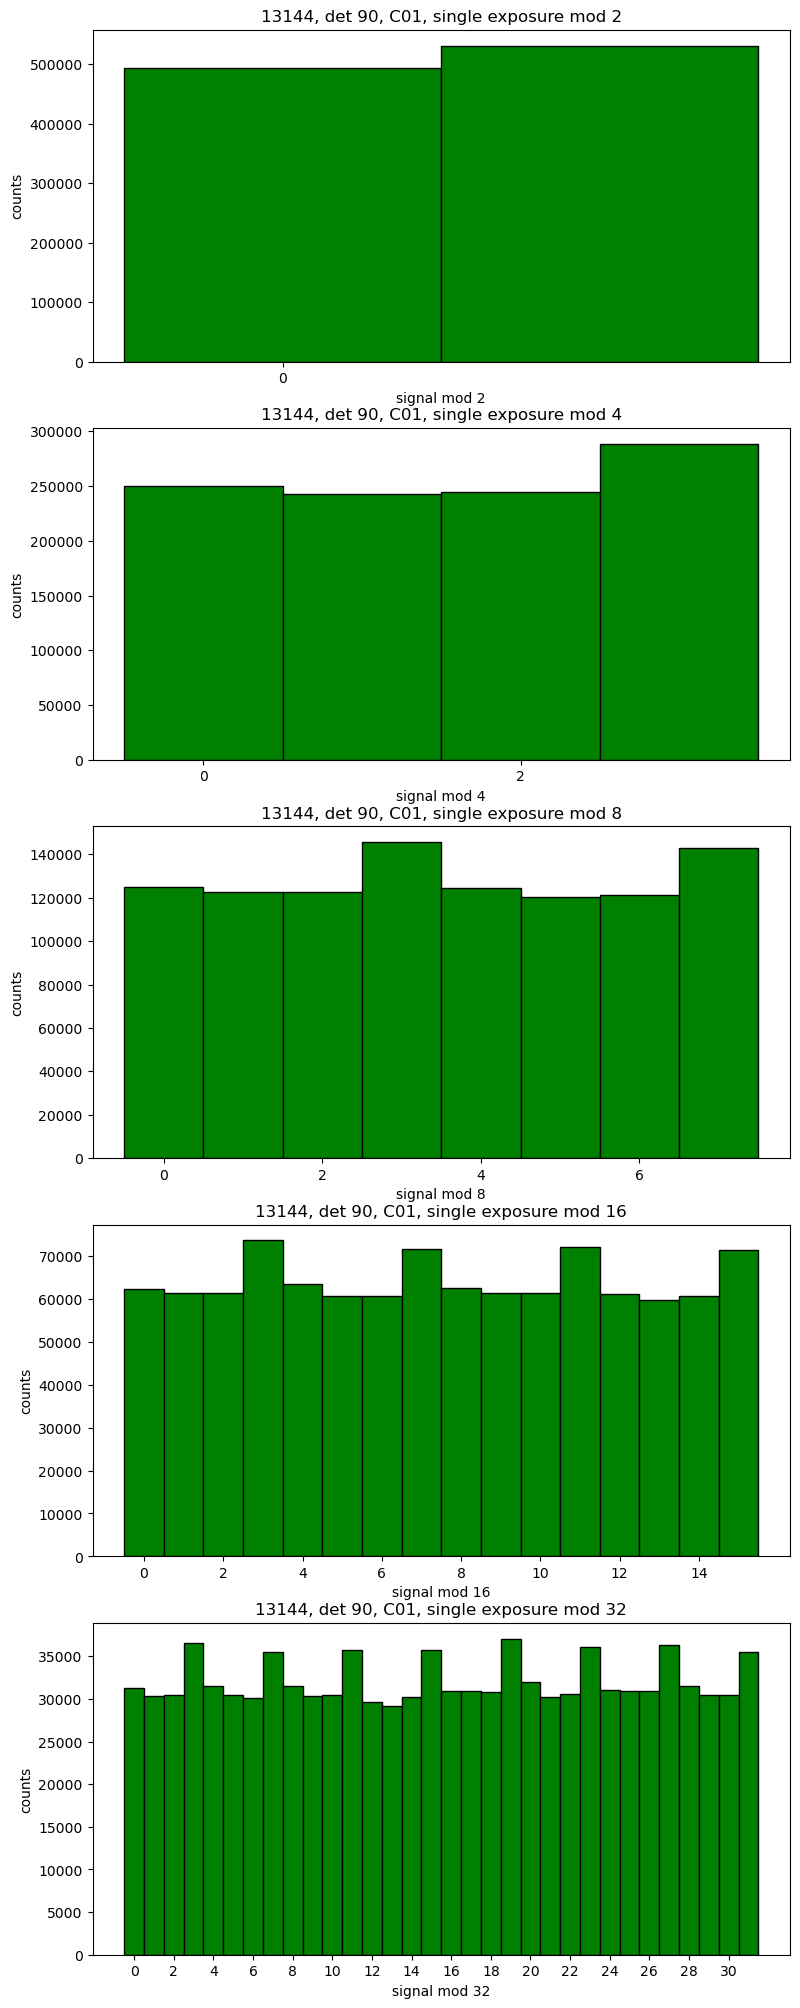

In [77]:
getBinsSorted(610)

R22_S00
the mean signal in ADU is 132865.12248981488


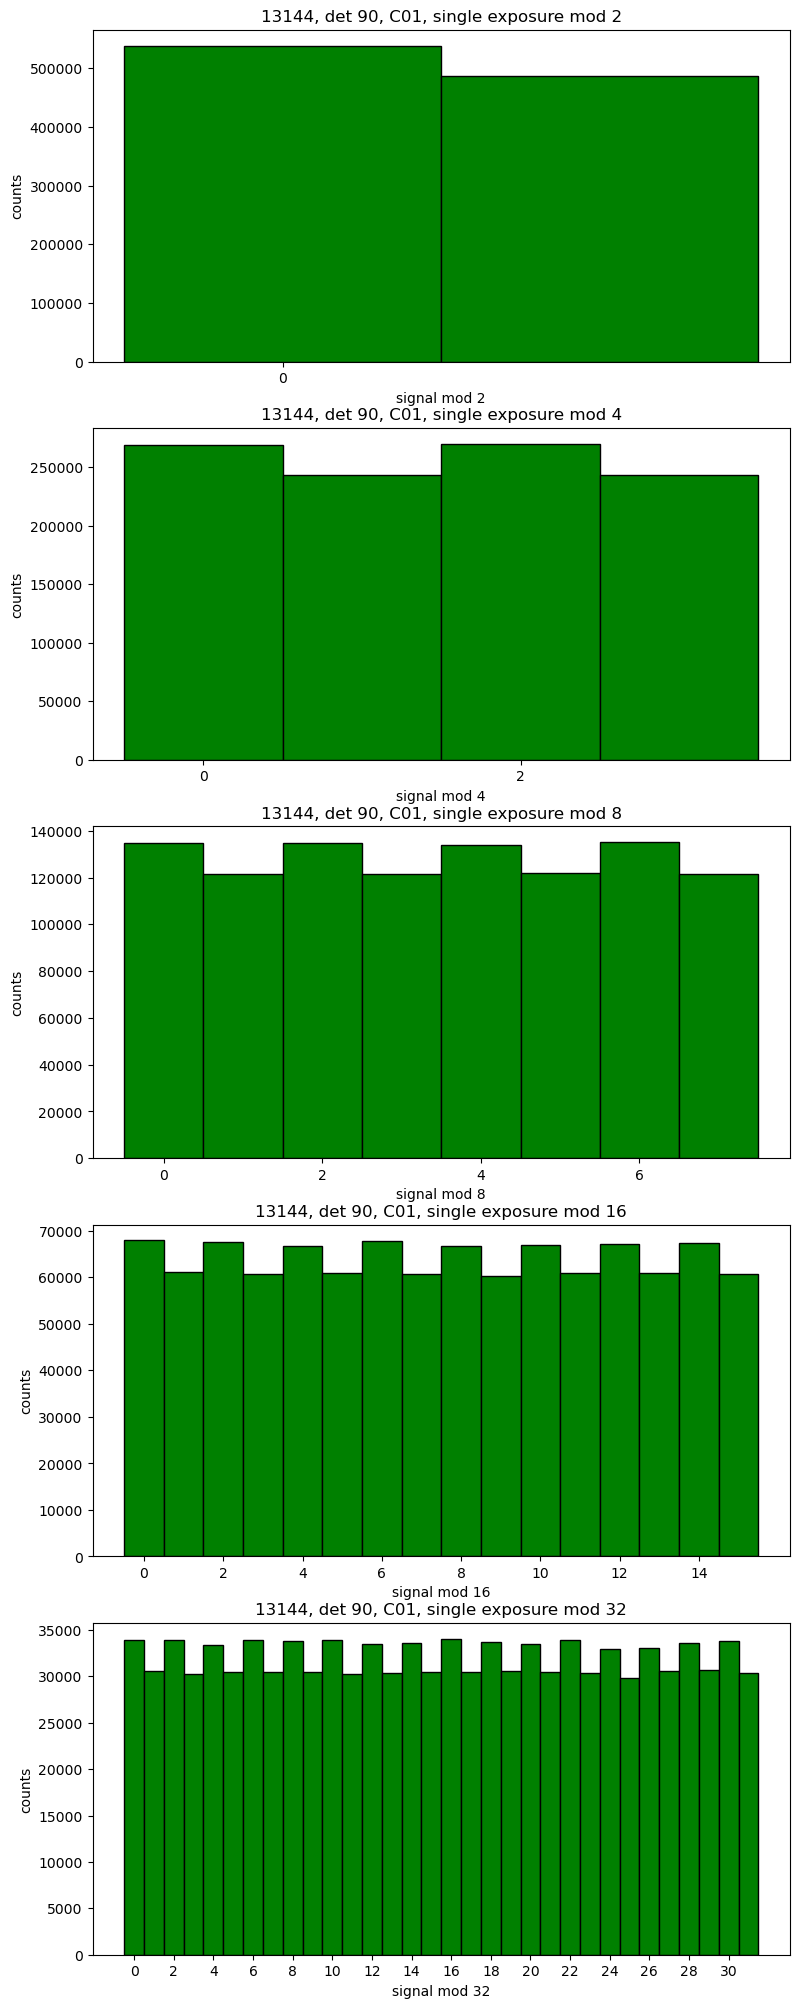

In [76]:
getBinsSorted(650)

## Now want to convert these into probabilities to be easier to see 

In [67]:
def getProbabilities(bindictionary, binsrepresented):
    numberbins = len(binsrepresented)
    probabilitiesdict = {}
    for key in bindictionary:
        probabilities = bindictionary[key] / numberbins
        probabilitiesdict[key] = probabilities

    return probabilitiesdict
 
def getBinsProbs(exposure):
    flattenedarraydict =  getFlattenedArray(90, "13144", "flat", exposure)
    binsrepresented = flattenedarraydict["C01"]

    print("the mean signal in ADU is", np.mean(binsrepresented))
    
    seeMods = [2, 4, 8, 16, 32]
    
    fig, axes = plt.subplots(5, 1, figsize=(9, 25))
    
    index = 0 
    for x in seeMods: 
        bindictionary = sortBinsModGeneric(binsrepresented, x)
        probabilitiesdict = getProbabilities(bindictionary, binsrepresented)
        expectedprob = 1/x 
        axes[index].scatter(probabilitiesdict.keys(), probabilitiesdict.values(), label=f'expected={expectedprob}')
        axes[index].set_title(f"13144, det 90, C01, single exposure mod {x} bit probs")
        axes[index].set_xticks(np.arange(0, x, 2))
        axes[index].legend()
        axes[index].set_ylabel("bit prob")
        axes[index].set_xlabel(f"signal mod {x}")
        axes[index].axhline(y=expectedprob, linestyle = 'dashed') 
        index +=1 

R22_S00
the mean signal in ADU is 26737.71284965035


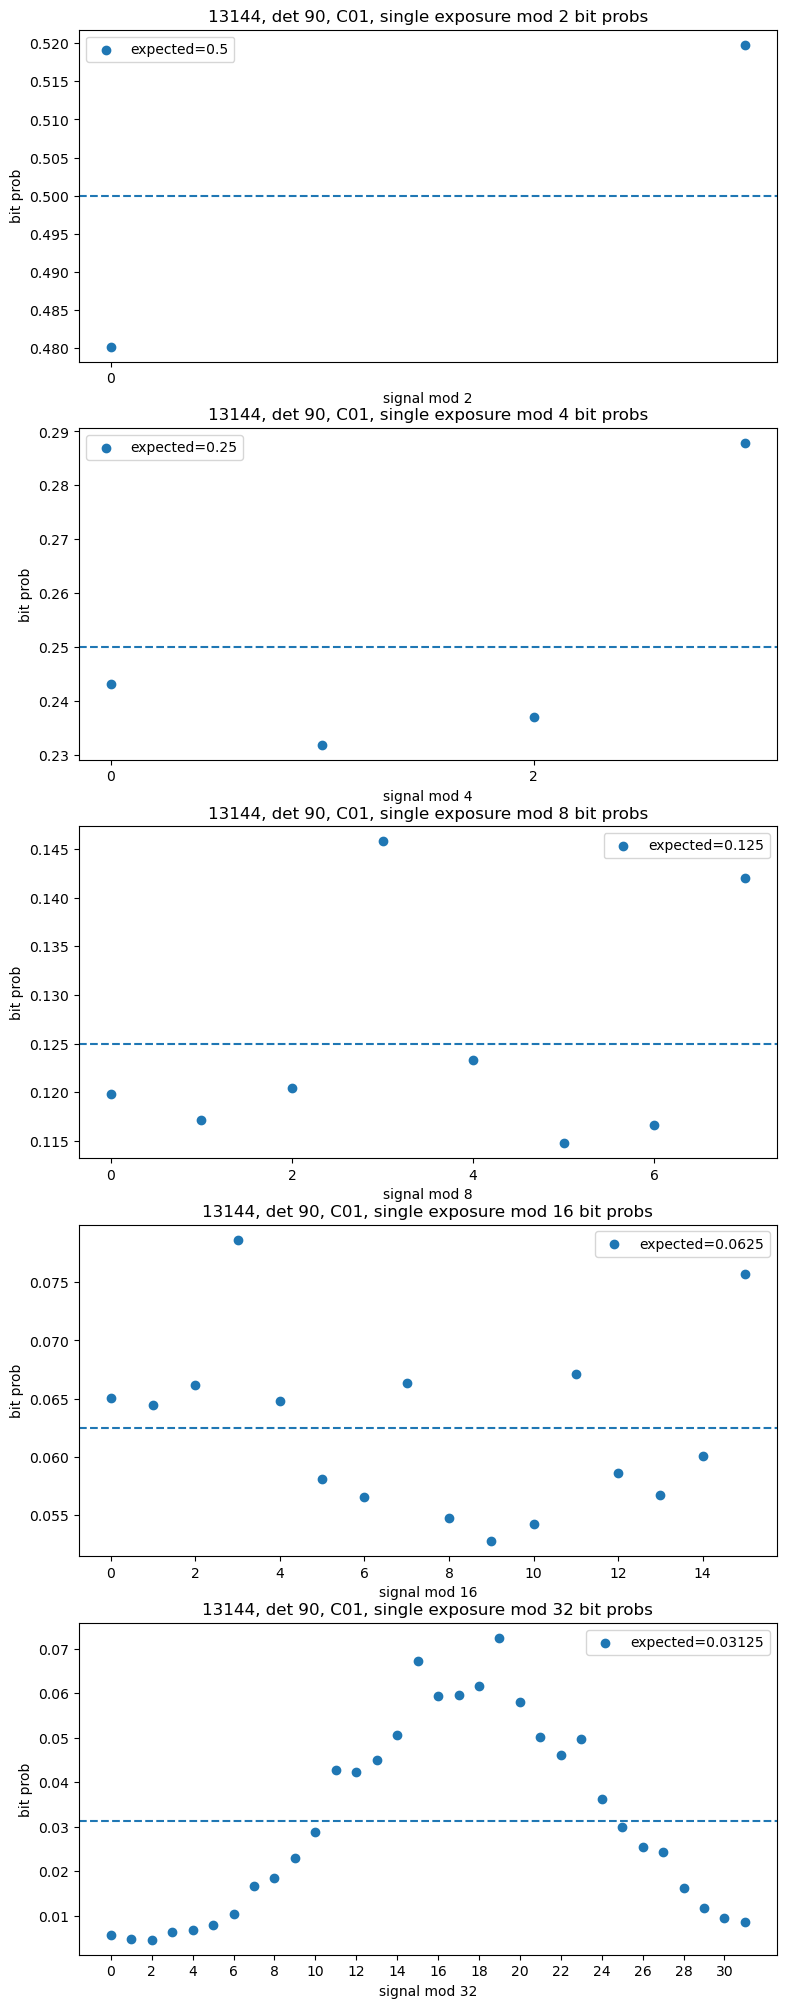

In [68]:
getBinsProbs(1)

R22_S00
the mean signal in ADU is 60453.565958455605


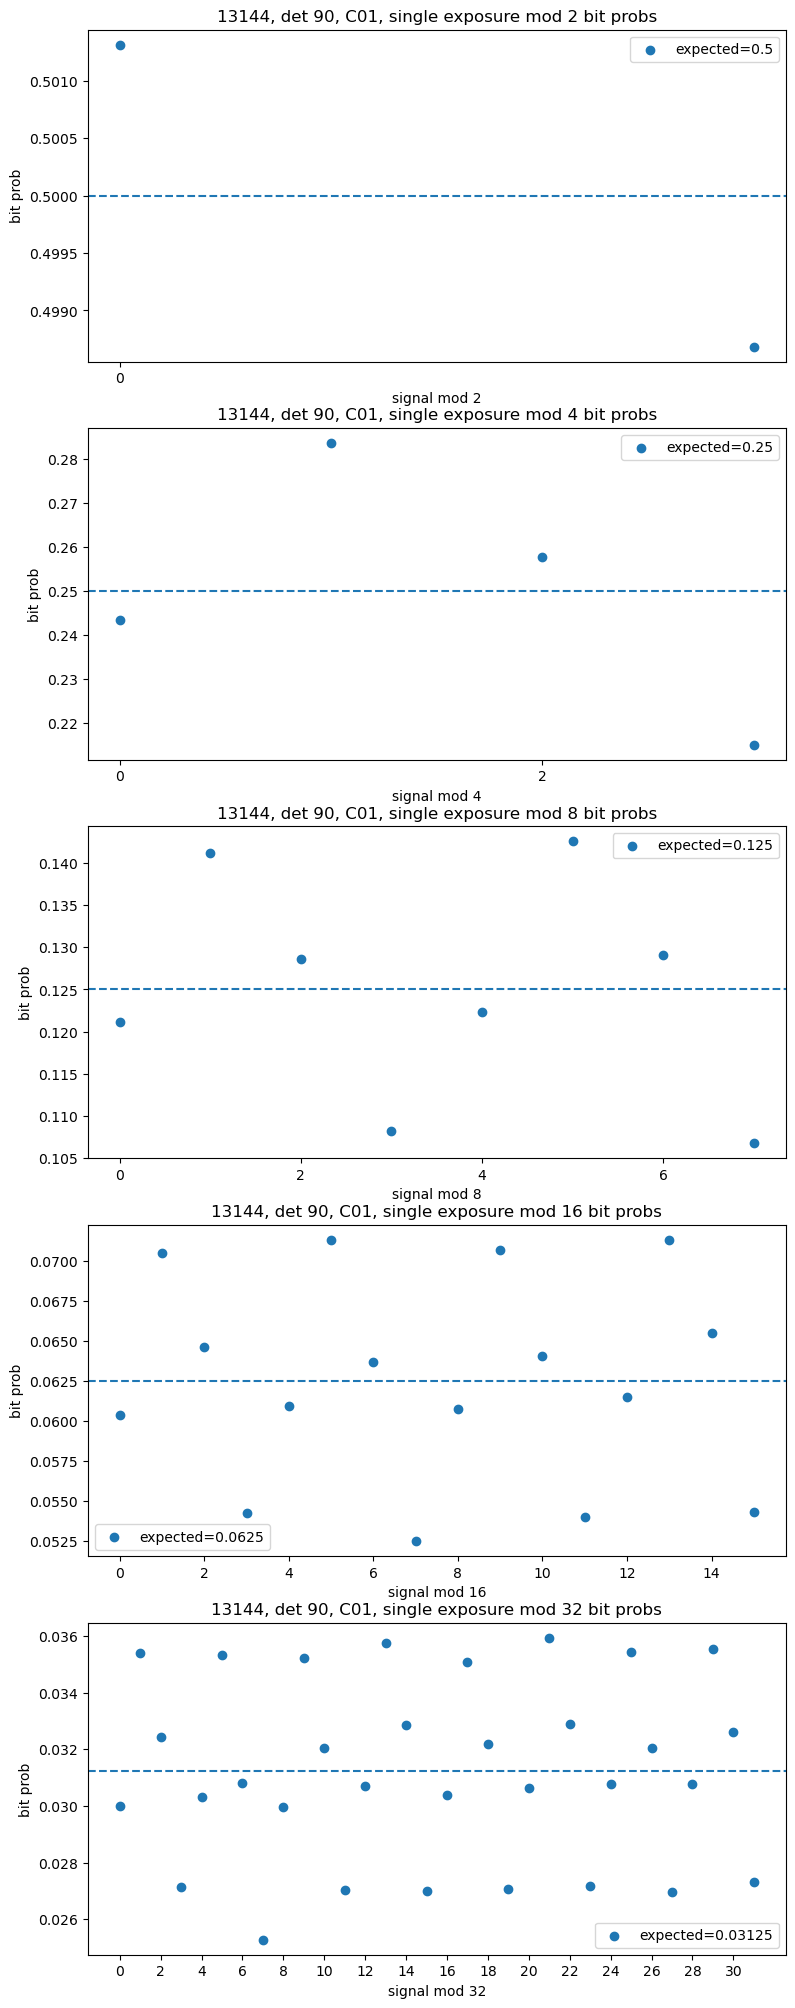

In [72]:
getBinsProbs(610)

R22_S00
the mean signal in ADU is 132847.396304867


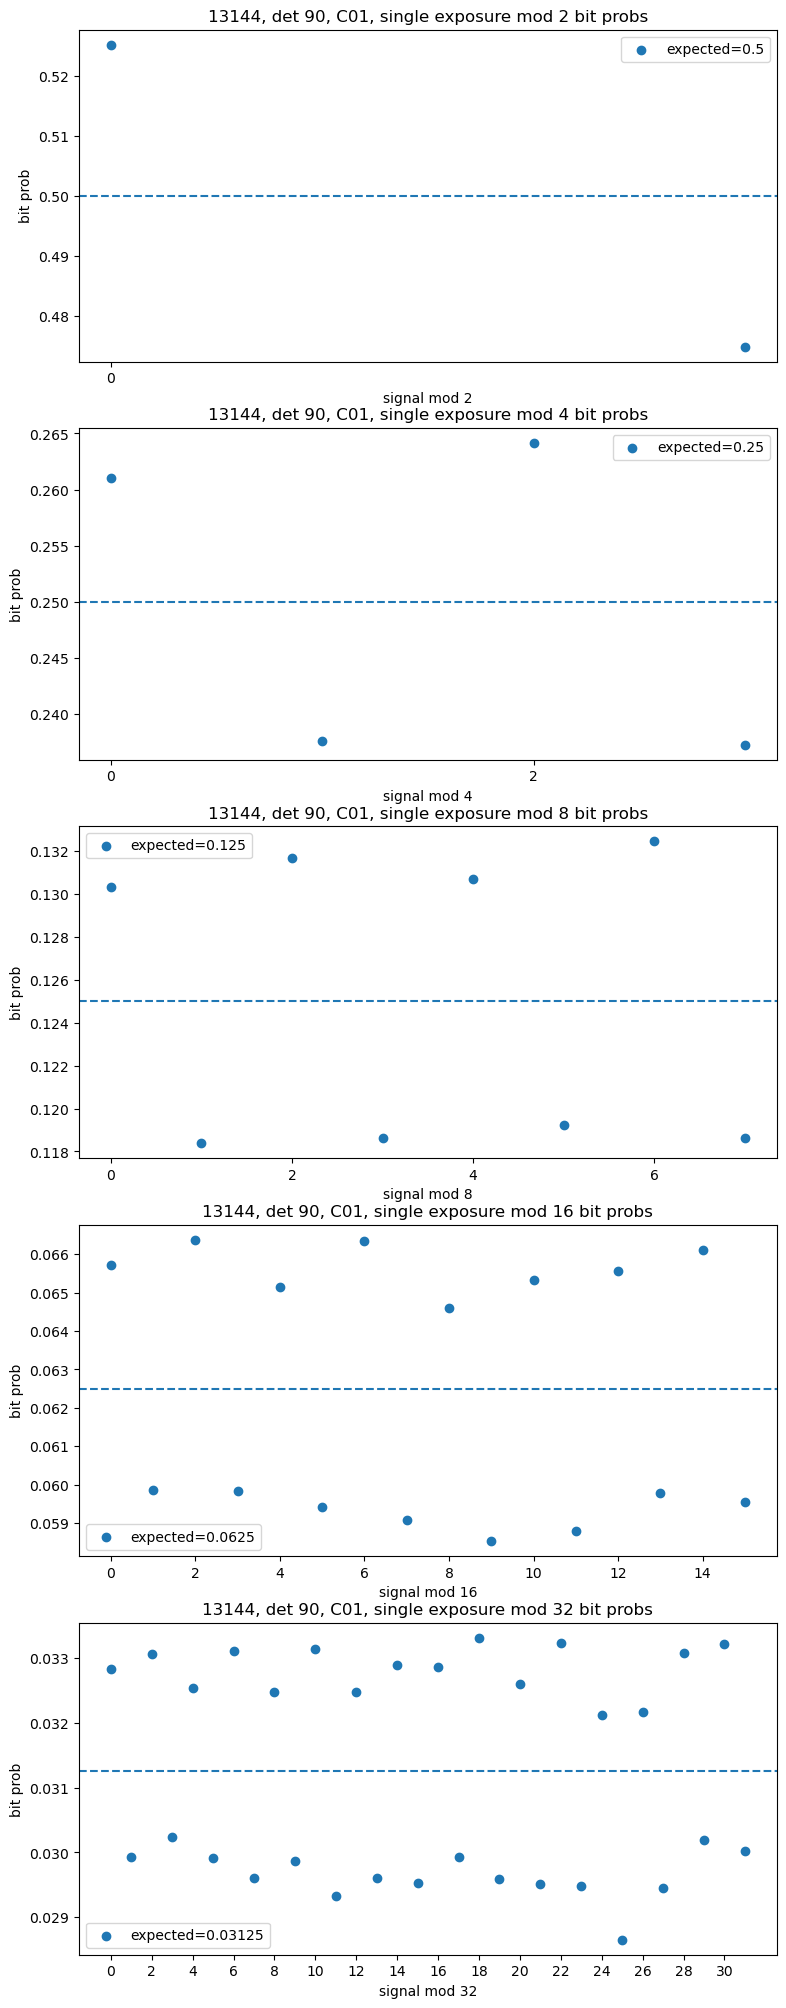

In [75]:
getBinsProbs(650)

## Understand dependence between flux and the behavior seen

In [86]:
def seeManyExpOnSamePlot():
    flattenedarraydict1 =  getFlattenedArray(90, "13144", "flat", 0)
    flattenedarraydict2 =  getFlattenedArray(90, "13144", "flat", 610)
    flattenedarraydict3 =  getFlattenedArray(90, "13144", "flat", 650)

    binsrepresented1 = flattenedarraydict1["C01"]
    binsrepresented2 = flattenedarraydict2["C01"]
    binsrepresented3 = flattenedarraydict3["C01"]

    flux1 = np.round(np.mean(binsrepresented1), 0)
    flux2 = np.round(np.mean(binsrepresented2), 0)
    flux3 = np.round(np.mean(binsrepresented3), 0) 

    seeMods = [2, 4, 8, 16, 32]
    
    fig, axes = plt.subplots(5, 1, figsize=(9, 25))
    
    index = 0 
    for x in seeMods: 
        bindictionary1 = sortBinsModGeneric(binsrepresented1, x)
        probabilitiesdict1 = getProbabilities(bindictionary1, binsrepresented1)

        bindictionary2 = sortBinsModGeneric(binsrepresented2, x)
        probabilitiesdict2 = getProbabilities(bindictionary2, binsrepresented2)
        
        bindictionary3 = sortBinsModGeneric(binsrepresented3, x)
        probabilitiesdic3 = getProbabilities(bindictionary3, binsrepresented3)

        expectedprob = 1/x 
        
        axes[index].scatter(probabilitiesdict1.keys(), probabilitiesdict1.values(), label=f'flux={flux1}')
        axes[index].scatter(probabilitiesdict2.keys(), probabilitiesdict2.values(), label=f'flux={flux2}')
        axes[index].scatter(probabilitiesdic3.keys(), probabilitiesdic3.values(), label=f'flux={flux3}')

        axes[index].set_title(f"13144, det 90, C01, 3 exposures mod {x} bit probs")
        axes[index].set_xticks(np.arange(0, x, 2))
        axes[index].legend()
        axes[index].set_ylabel("bit prob")
        axes[index].set_xlabel(f"signal mod {x}")
        axes[index].axhline(y=expectedprob, linestyle = 'dashed') 
        index +=1 

R22_S00
R22_S00
R22_S00


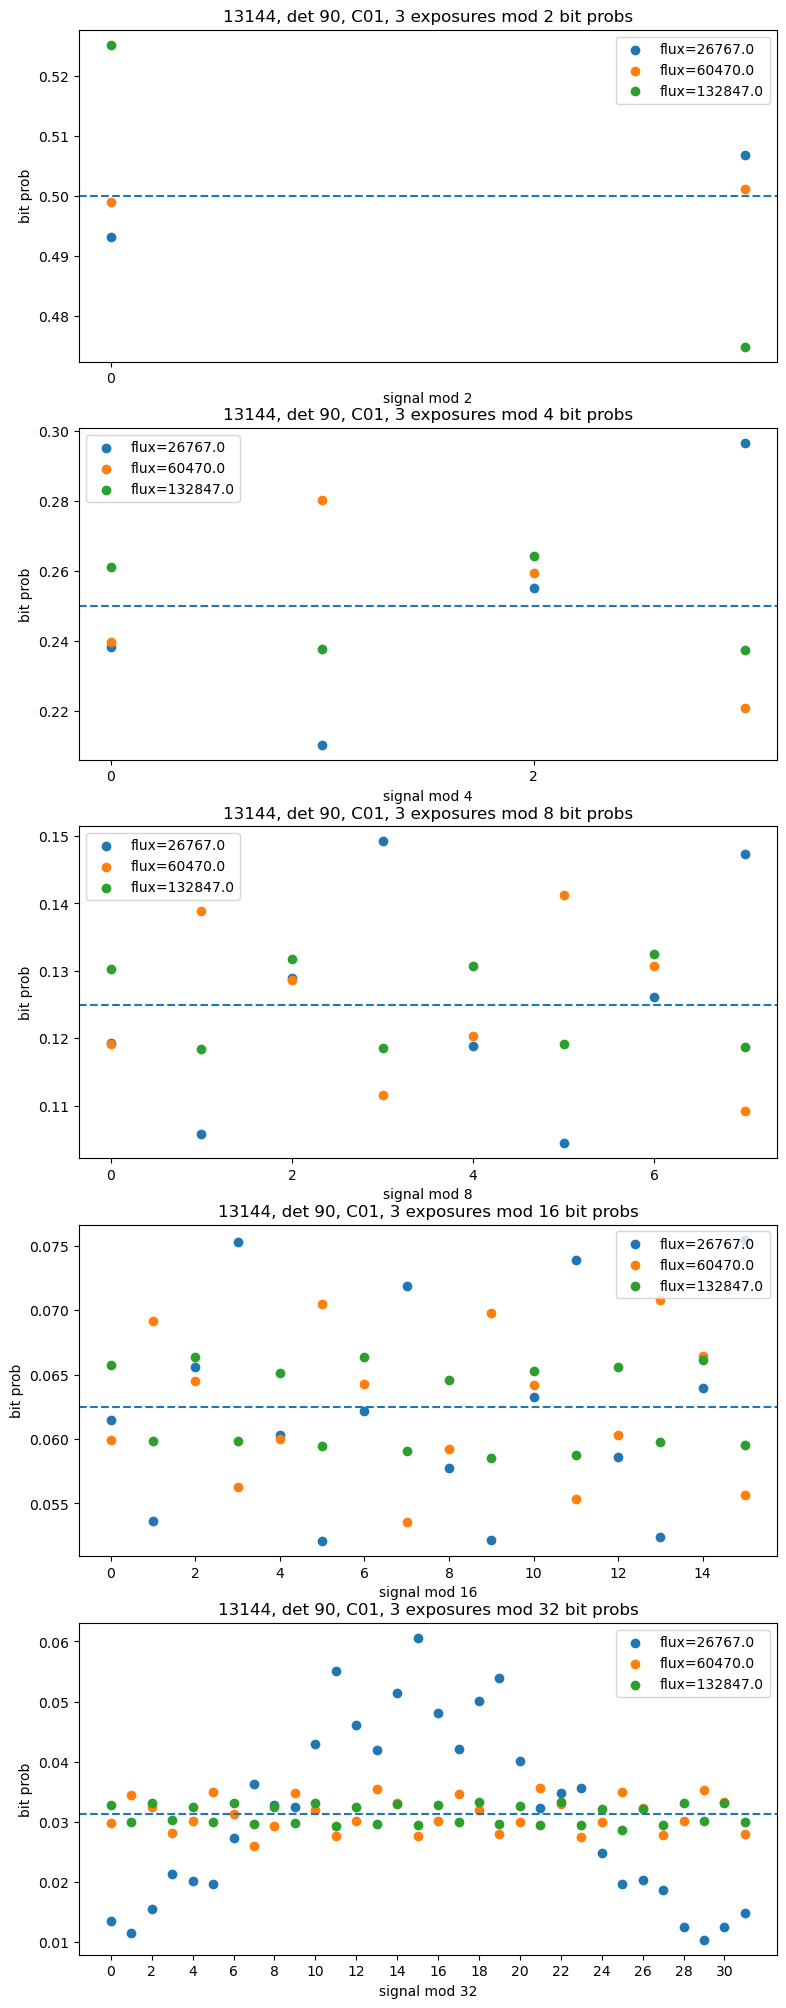

In [87]:
seeManyExpOnSamePlot()